In [1]:
import pandas as pd
import math
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from sklearn.metrics import r2_score

In [2]:
data = pd.read_csv('dataset.csv')
print(len(data))
data.head()

1000


,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,522,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43
1,738,16.42,Clear,Medium,Evening,Bike,20,2.0,84
2,741,9.52,Foggy,Low,Night,Scooter,28,1.0,59
3,661,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37
4,412,19.03,Clear,Low,Morning,Bike,16,5.0,68


In [3]:
data = data.dropna()
print(len(data))

883


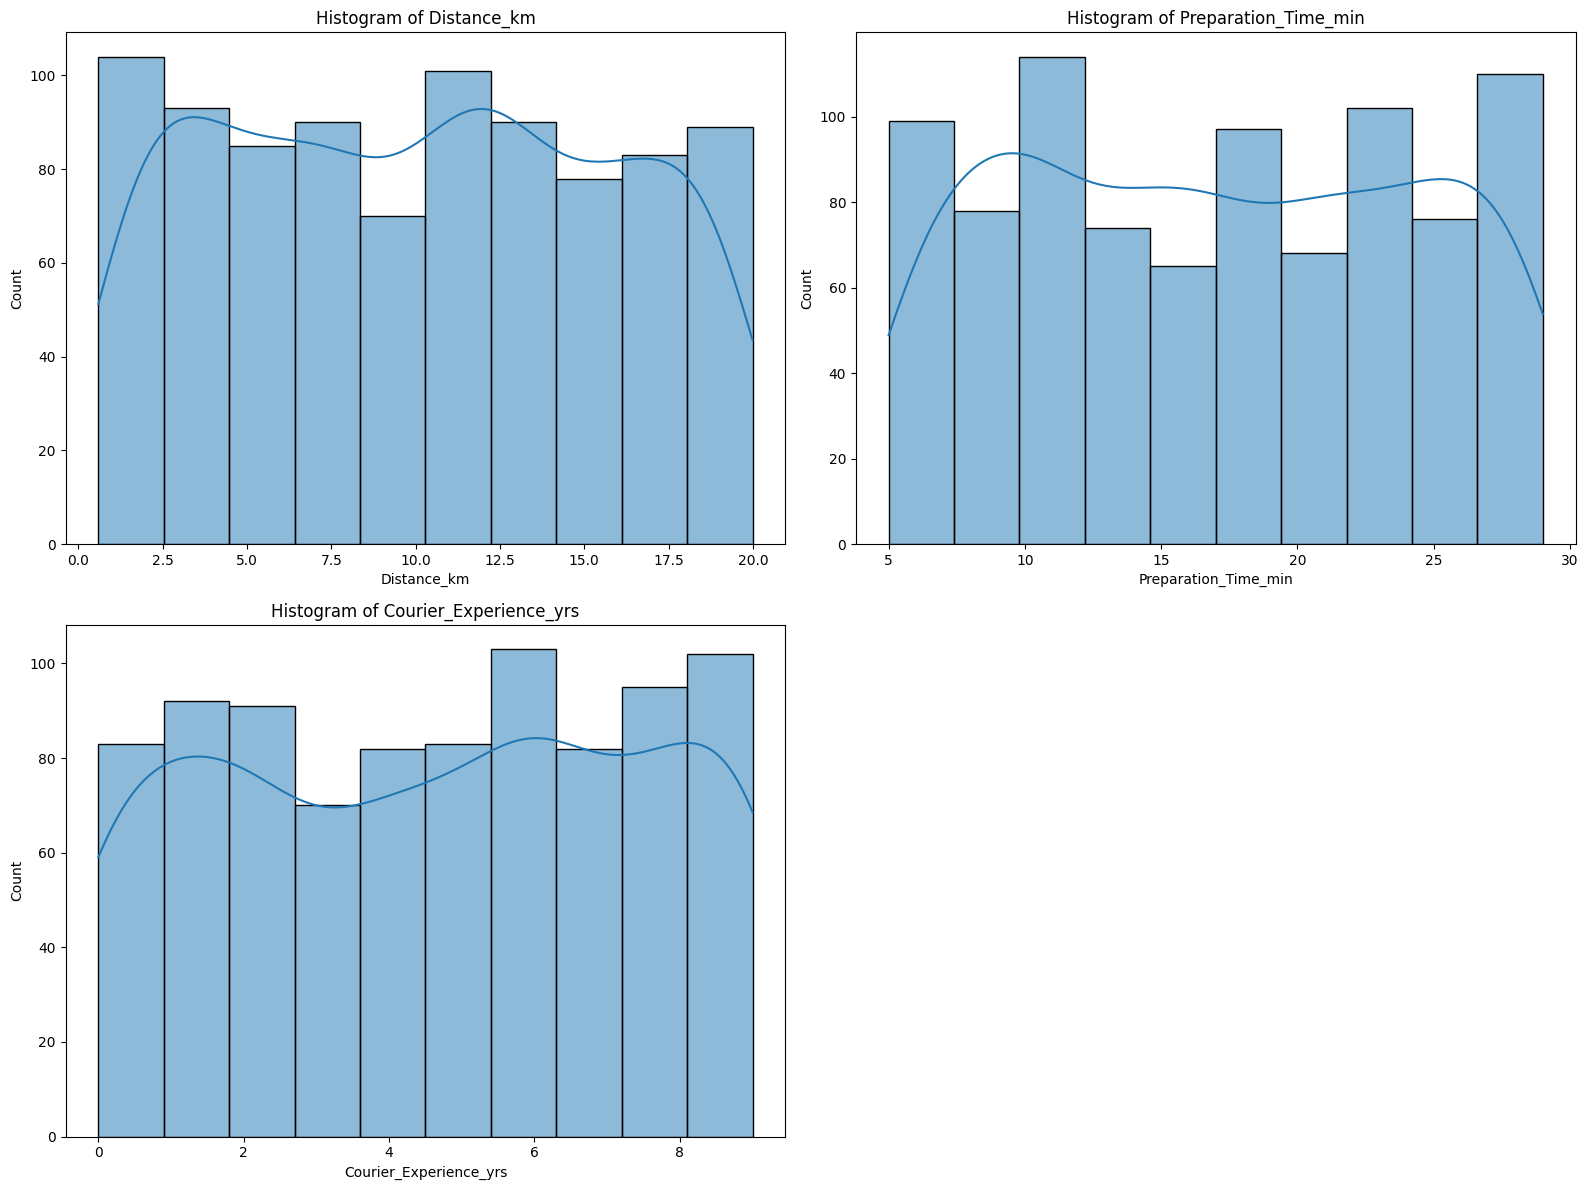

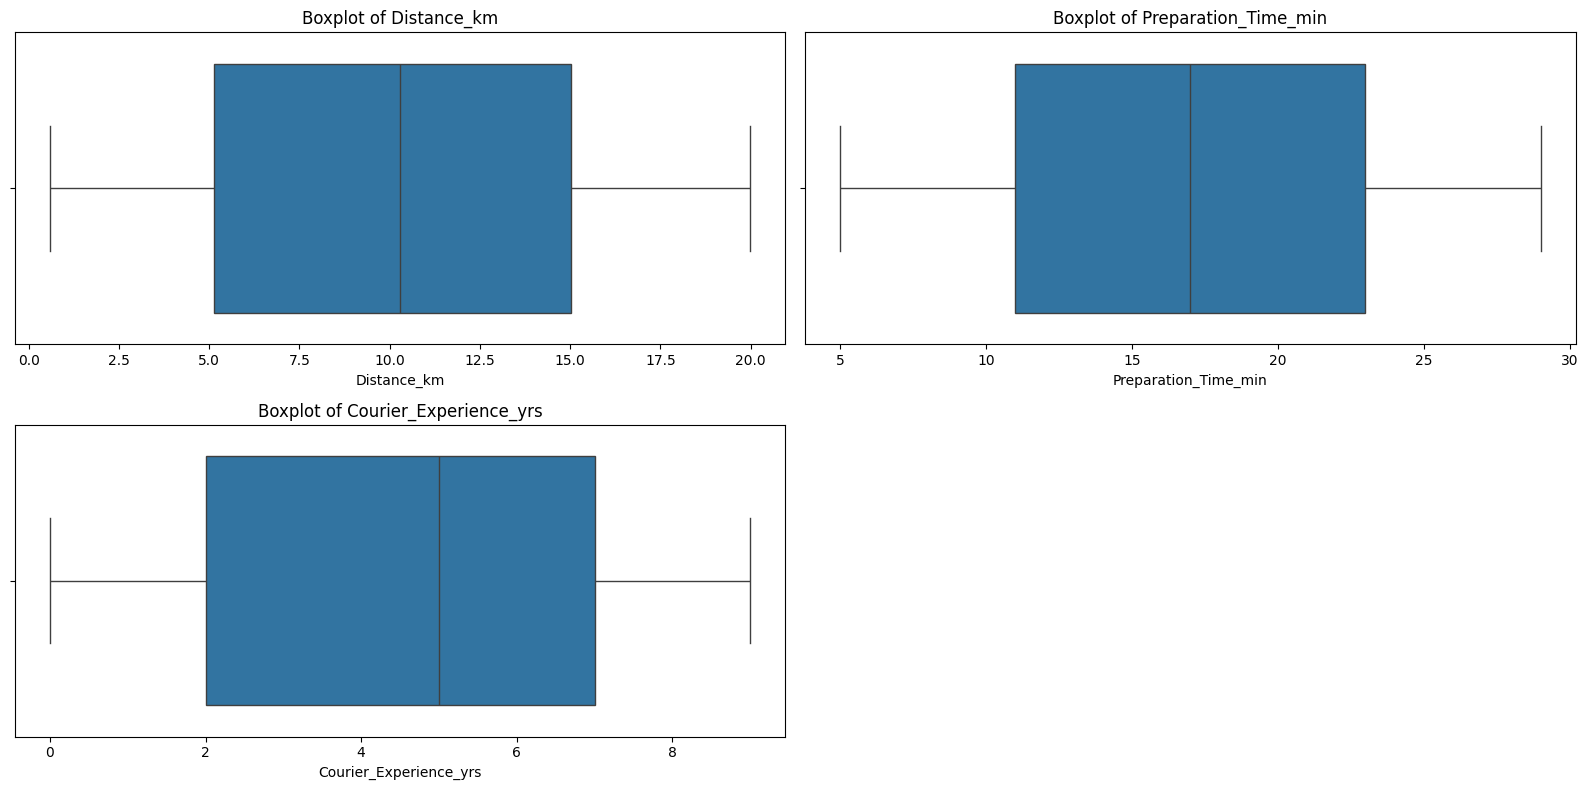

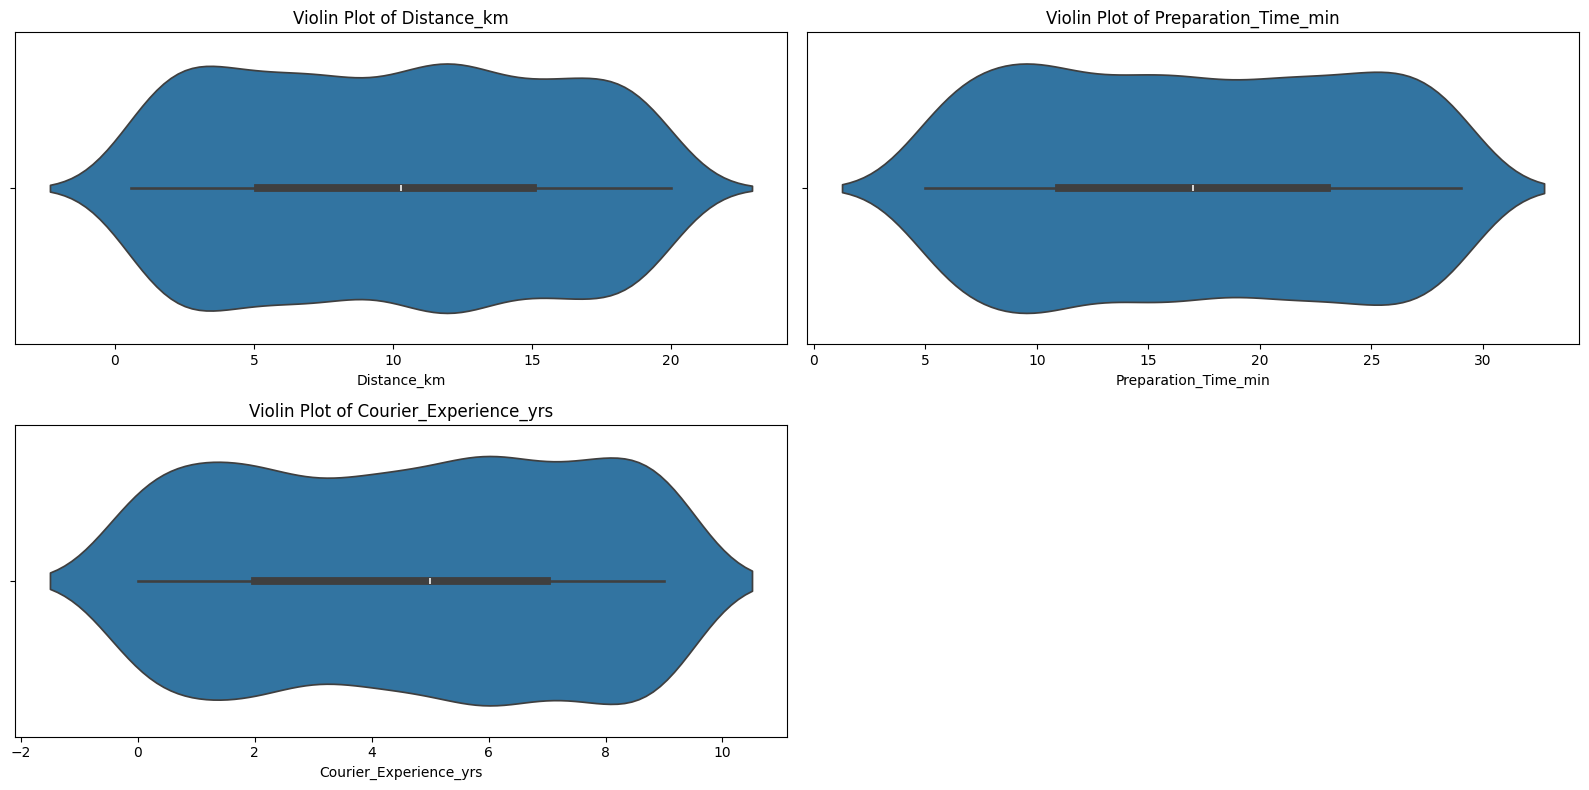

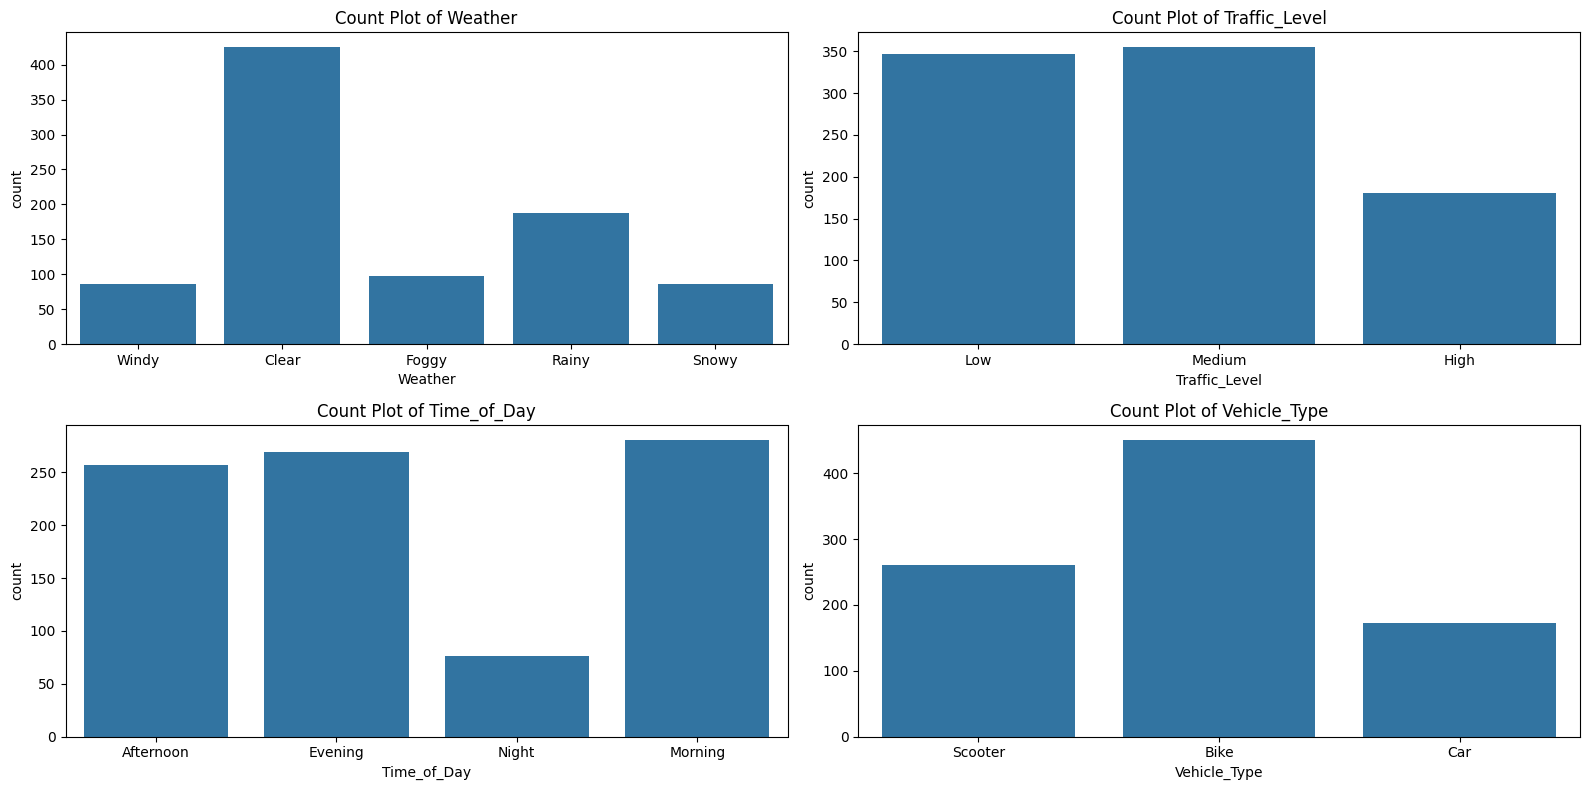

In [4]:
num_features = ["Distance_km", "Preparation_Time_min", "Courier_Experience_yrs"]
cat_features = ["Weather", "Traffic_Level", "Time_of_Day", "Vehicle_Type"]
plt.figure(figsize=(16, 12))


for i, col in enumerate(num_features, 1):
    plt.subplot(2, 2, i)
    sns.histplot(data[col], kde=True, bins=10)
    plt.title(f"Histogram of {col}")

plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 8))
for i, col in enumerate(num_features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=data[col])
    plt.title(f"Boxplot of {col}")

plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 8))
for i, col in enumerate(num_features, 1):
    plt.subplot(2, 2, i)
    sns.violinplot(x=data[col])
    plt.title(f"Violin Plot of {col}")

plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 8))
for i, col in enumerate(cat_features, 1):
    plt.subplot(2, 2, i)
    sns.countplot(x=data[col])
    plt.title(f"Count Plot of {col}")

plt.tight_layout()
plt.show()

# Observations
- Most couriers use bikes as their vehicle
- Most meals take between 10-30 minutes to prepare
- Few deliveries occur in the night
- Most deliveries occur in clear weather
- Most deliveries occur in low or medium traffic
- The experience of couriers is uniformly difstributed between 2 and 8 years


In [5]:

scaler = StandardScaler()  
data[num_features] = scaler.fit_transform(data[num_features])
encoder = OneHotEncoder(drop="first", sparse_output=False)  
encoded_cats = encoder.fit_transform(data[cat_features])
encoded_data = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(cat_features))
data = data.drop(columns=cat_features).reset_index(drop=True)
data = data.drop(columns='Order_ID').reset_index(drop=True)
data = pd.concat([data, encoded_data], axis=1)
print(len(data))
data.head()

883


,Distance_km,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min,Weather_Foggy,Weather_Rainy,Weather_Snowy,Weather_Windy,Traffic_Level_Low,Traffic_Level_Medium,Time_of_Day_Evening,Time_of_Day_Morning,Time_of_Day_Night,Vehicle_Type_Car,Vehicle_Type_Scooter
0,-0.373166,-0.691730,-1.246308,43,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.120143,0.410793,-0.903903,84,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2,-0.093501,1.513315,-1.246308,59,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
3,-0.459353,-1.656437,-1.246308,37,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,1.579216,-0.140469,0.123312,68,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [6]:
train_set = data.iloc[:math.floor(0.7 * len(data)), :]
val_set = data.iloc[math.floor(0.7 * len(data)):math.floor(0.85 * len(data)), :]
test_set = data.iloc[math.floor(0.85 * len(data)): , :]
print(len(train_set), len(val_set), len(test_set))

618 132 133


In [7]:
cols = list(col for col in train_set.columns if col != "Delivery_Time_min") 
n = len(cols)
def df_to_mat(df, cols):
    Y = np.array(df["Delivery_Time_min"])
    df = df.drop(columns="Delivery_Time_min")
    m = len(df)
    X = np.ones((m, n + 1))
    for i in range (m):
        X[i][1:] = np.array(df.iloc[i])
    return X, Y
X_train, Y_train = df_to_mat(train_set, cols)
X_val, Y_val = df_to_mat(val_set, cols)
X_test, Y_test = df_to_mat(test_set, cols)
Y_mean = np.mean(Y_train)
Y_std = np.std(Y_train)
Y_train = (Y_train - Y_mean) / Y_std
Y_val = (Y_val - Y_mean) / Y_std
Y_test = (Y_test - Y_mean) / Y_std 
mses = []



In [8]:
class LinearRegressionModel():
    def __init__(self, epochs, X_train, Y_train, X_val, Y_val, X_test, Y_test, Y_mean, Y_std, theta, gd_method='Batch', lr=0.05, regularization=None, Lambda=None, print_results=1, epsilon=0.05):
        self.lr = lr
        self.epochs = epochs
        self.theta = theta
        self.X_train = X_train
        self.Y_train = Y_train
        self.X_val = X_val
        self.Y_val = Y_val
        self.X_test = X_test
        self.Y_test = Y_test
        self.Y_mean = Y_mean
        self.Y_std = Y_std 
        self.gd_method = gd_method
        self.train_loss = []
        self.val_loss = []
        self.regularization = regularization
        self.Lambda = Lambda
        self.print_results = print_results
        self.epsilon = epsilon
        self.iters_for_convergence = 0
    def batch_gd(self):
        for i in range(self.epochs):
            h_train = np.matmul(self.X_train, self.theta)
            train_error = h_train - self.Y_train
            grad = (1 / self.X_train.shape[0]) * np.matmul(np.transpose(self.X_train), train_error)
            self.theta -= self.lr * grad
            h_val = np.matmul(self.X_val, self.theta)
            h_val = h_val * self.Y_std + self.Y_mean
            Y_val_original = self.Y_val * self.Y_std + self.Y_mean 
            if i % 10 == 0:  
                mse_val = np.mean((h_val - Y_val_original) ** 2)
                self.train_loss.append(np.mean(train_error ** 2))
                if len(self.val_loss) > 0:
                    if abs(self.val_loss[-1] - mse_val) < self.epsilon and self.iters_for_convergence == 0:
                        self.iters_for_convergence = i
                self.val_loss.append(mse_val)
        
    def stochastic_gd(self):
        for i in range(self.epochs):
            epoch_train_errors = []
            for j in range(self.X_train.shape[0]):
                x_j = self.X_train[j].reshape(1, -1)
                h_train = np.matmul(x_j, self.theta)
                train_error = h_train - self.Y_train[j]
                grad = np.matmul(np.transpose(x_j), train_error)
                if self.regularization is not None:
                    if self.regularization == 'Lasso':
                        reg_term = self.Lambda * np.sign(self.theta)
                    elif self.regularization == 'Ridge':
                        reg_term = 2 * self.Lambda * self.theta
                    grad += reg_term
                self.theta -= self.lr * grad
                epoch_train_errors.append(train_error ** 2)
            h_val = np.matmul(self.X_val, self.theta)
            h_val = h_val * self.Y_std + self.Y_mean
            Y_val_original = self.Y_val * self.Y_std + self.Y_mean 
            if i % 10 == 0:  
                mse_val = np.mean((h_val - Y_val_original) ** 2)
                self.train_loss.append(np.mean(epoch_train_errors))
                if len(self.val_loss) > 0:
                    if abs(self.val_loss[-1] - mse_val) < self.epsilon and self.iters_for_convergence == 0:
                        self.iters_for_convergence = i
                self.val_loss.append(mse_val)
        
    def mini_batch_gd(self, batch_size=32):
        for i in range(self.epochs):
            epoch_train_errors = []
            batch_train_errors = []
            x_js = {}
            for j in range(self.X_train.shape[0]):
                x_j = self.X_train[j].reshape(1, -1)
                x_js[j % batch_size] = x_j
                h_train = np.matmul(x_j, self.theta)
                train_error = h_train - self.Y_train[j]
                batch_train_errors.append(train_error)
                epoch_train_errors.append(train_error ** 2)
                if (j + 1) % batch_size == 0:
                    batch_error = 0
                    for k in range(batch_size):
                        batch_error += np.matmul(np.transpose(x_js[k]), batch_train_errors[k]) 
                    grad = (1 / batch_size) * batch_error
                    self.theta -= self.lr * grad
                    batch_train_errors = []
                    x_js = {}
            h_val = np.matmul(self.X_val, self.theta)
            h_val = h_val * self.Y_std + self.Y_mean
            Y_val_original = self.Y_val * self.Y_std + self.Y_mean 
            if i % 10 == 0:  
                mse_val = np.mean((h_val - Y_val_original) ** 2)
                self.train_loss.append(np.mean(epoch_train_errors))
                if len(self.val_loss) > 0:
                    if abs(self.val_loss[-1] - mse_val) < self.epsilon and self.iters_for_convergence == 0:
                        self.iters_for_convergence = i
                self.val_loss.append(mse_val)     
    def train(self):
        if self.gd_method == 'Batch':
            self.batch_gd()
        elif self.gd_method == 'Stochastic':
            self.stochastic_gd()
        elif self.gd_method == 'MiniBatch':
            self.mini_batch_gd()
    
    def evaluate(self):
        preds = np.matmul(self.X_test, self.theta)
        preds = preds * self.Y_std + self.Y_mean
        Y_test_original = self.Y_test * self.Y_std + self.Y_mean
        mse = np.mean((preds - Y_test_original) ** 2)
        r2 = r2_score(Y_test_original, preds)
        title = f'Evaluation Results for {self.gd_method} Gradient Descent on the test set: '
        if self.regularization is not None:
            mses.append(mse)
            title += f"(with {self.regularization} Regularization) "
        if self.print_results:
            print(title)
            print(f"MSE: {mse}")
            print(f"R² Score: {r2}")
    def plot_loss_graphs(self):
        plt.figure(figsize=(10, 5))
        plt.plot(range(0, self.epochs, 10), self.train_loss, label="Training Loss (MSE)", marker="o")
        plt.plot(range(0, self.epochs, 10), self.val_loss, label="Validation Loss (MSE)", marker="s")
        plt.xlabel("Epochs")
        plt.ylabel("Mean Squared Error (MSE)")
        title = f"Training & Validation Loss Over Epochs for {self.gd_method} Gradient Descent "
        if self.regularization is not None:
            title += f"(with {self.regularization} Regularization) "
        if self.print_results:
            title += f"(lambda = {self.Lambda})"
        plt.title(title)
        plt.legend()
        plt.grid(True)
        plt.show()
        
    

Evaluation Results for Batch Gradient Descent on the test set: 
MSE: 113.88798486546041
R² Score: 0.7474948881060143


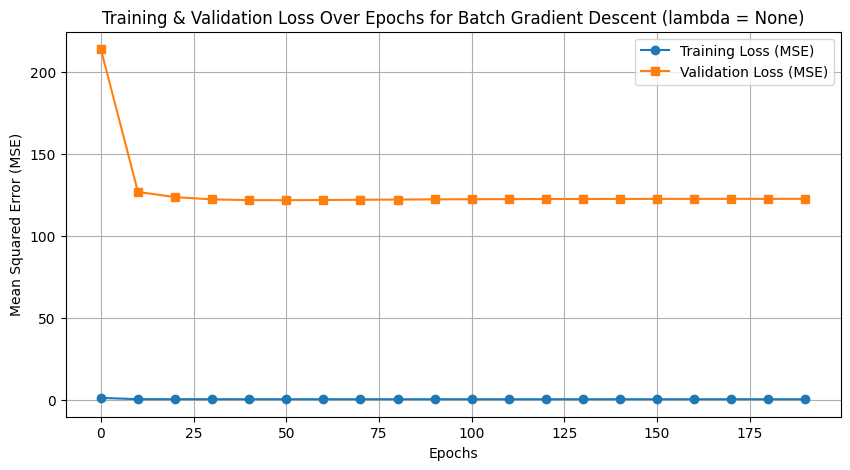

Evaluation Results for Stochastic Gradient Descent on the test set: 
MSE: 118.45636762882071
R² Score: 0.7373661637967769


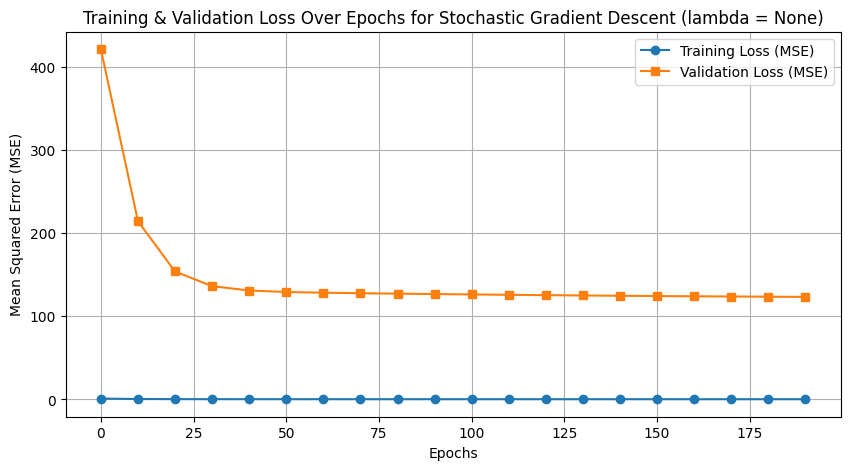

Evaluation Results for MiniBatch Gradient Descent on the test set: 
MSE: 114.30012692416274
R² Score: 0.746581113252839


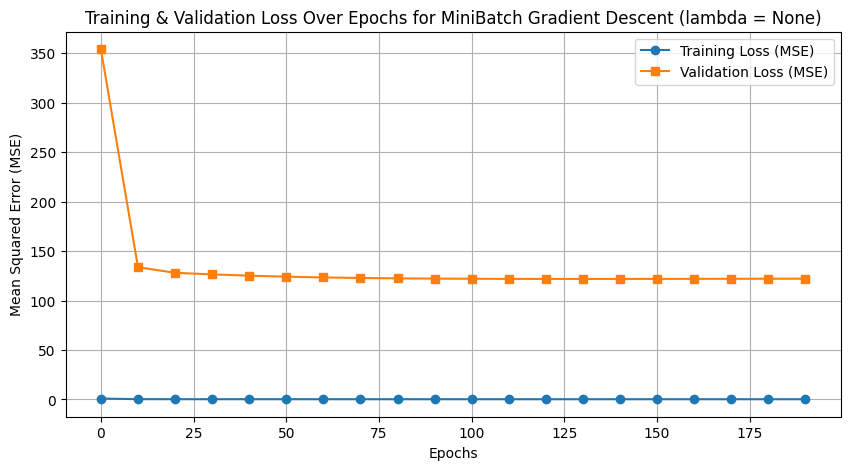

Evaluation Results for Stochastic Gradient Descent on the test set: (with Lasso Regularization) 
MSE: 285.4439215703287
R² Score: 0.3671321040518917


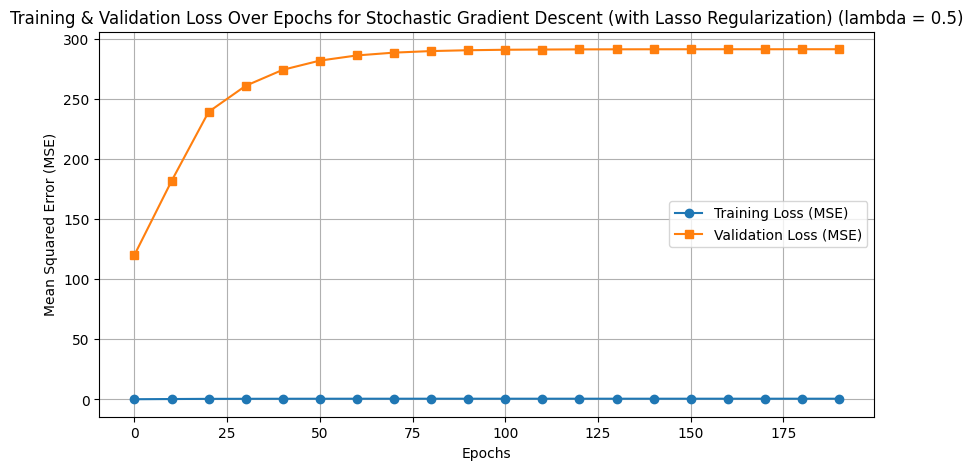

Evaluation Results for Stochastic Gradient Descent on the test set: (with Ridge Regularization) 
MSE: 206.53382040186983
R² Score: 0.5420865028732049


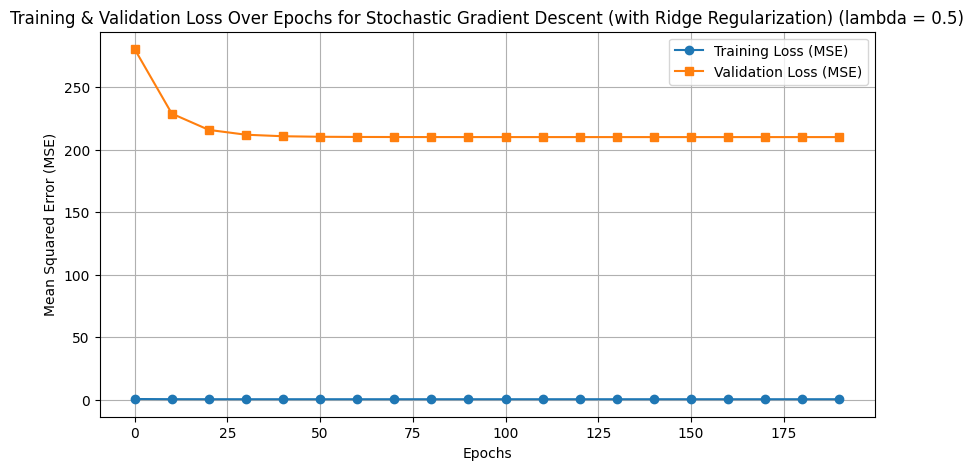

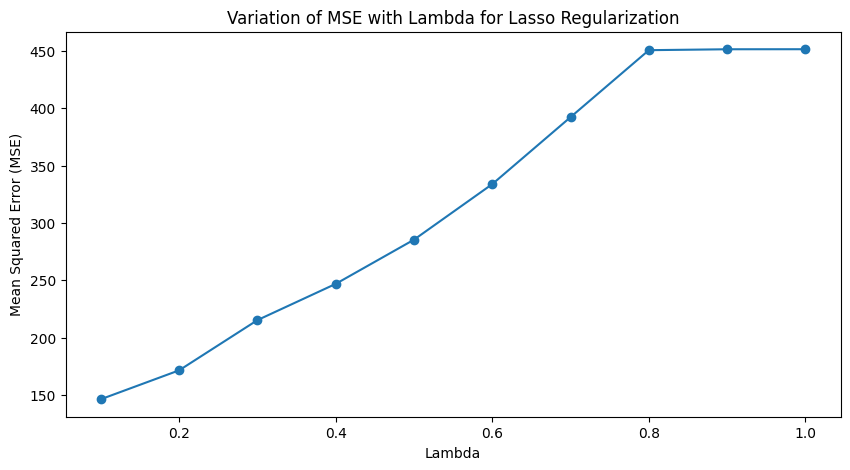

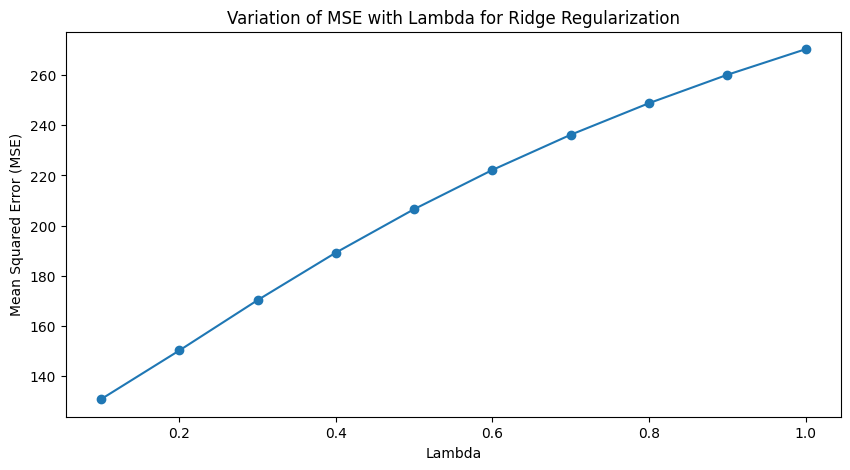

In [9]:
epochs = 200
theta = np.zeros((n + 1,))
# theta = np.random.rand(n + 1,)
bgd_model = LinearRegressionModel(epochs, X_train, Y_train, X_val, Y_val, X_test, Y_test, Y_mean, Y_std, theta, gd_method='Batch', lr=0.5)
bgd_model.train()
bgd_model.evaluate()
bgd_model.plot_loss_graphs()
theta = np.zeros((n + 1,))
# theta = np.random.rand(n + 1,)
sgd_model = LinearRegressionModel(epochs, X_train, Y_train, X_val, Y_val, X_test, Y_test, Y_mean, Y_std, theta, gd_method='Stochastic', lr=0.0001)
sgd_model.train()
sgd_model.evaluate()
sgd_model.plot_loss_graphs()
theta = np.zeros((n + 1,))
# theta = np.random.rand(n + 1,)
mbgd_model = LinearRegressionModel(epochs, X_train, Y_train, X_val, Y_val, X_test, Y_test, Y_mean, Y_std, theta, gd_method='MiniBatch', lr=0.01)
mbgd_model.train()
mbgd_model.evaluate()
mbgd_model.plot_loss_graphs()

lambdas = [0.1 * i for i in range(1, 11)]
regs = ['Lasso', 'Ridge']
for reg in regs:
    sgd_model_with_reg = LinearRegressionModel(epochs, X_train, Y_train, X_val, Y_val, X_test, Y_test, Y_mean, Y_std, theta, gd_method='Stochastic', lr=0.0001, regularization=reg, Lambda=0.5)
    sgd_model_with_reg.train()
    sgd_model_with_reg.evaluate()
    sgd_model_with_reg.plot_loss_graphs()
    del sgd_model_with_reg
mses = []
for reg in regs:
    for L in lambdas:
        sgd_model_with_reg = LinearRegressionModel(epochs, X_train, Y_train, X_val, Y_val, X_test, Y_test, Y_mean, Y_std, theta, gd_method='Stochastic', lr=0.0001, regularization=reg, Lambda=L, 
                                                         print_results=0)
        sgd_model_with_reg.train()
        sgd_model_with_reg.evaluate()
        del sgd_model_with_reg
    plt.figure(figsize=(10, 5))
    plt.plot(lambdas, mses, marker="o")
    plt.title(f"Variation of MSE with Lambda for {reg} Regularization")
    plt.xlabel("Lambda")
    plt.ylabel("Mean Squared Error (MSE)")
    plt.show()
    mses = []

        

In [10]:
def plot_best_fit(model, X, Y, dataset_name):
    predictions = np.matmul(X, model.theta) * model.Y_std + model.Y_mean  
    Y_original = Y * model.Y_std + model.Y_mean
    
    plt.figure(figsize=(10, 6))
    plt.scatter(Y_original, predictions, label='Predictions', alpha=0.6)
    plt.plot(Y_original, Y_original, color='red', linestyle='--', label='Perfect Fit')
    plt.xlabel("True Delivery Time (min)")
    plt.ylabel("Predicted Delivery Time (min)")
    plt.title(f"Best Fit for {dataset_name} - {model.gd_method} (Reg: {model.regularization})")
    plt.legend()
    plt.grid()
    plt.show()
def plot_feature_weights(models, model_names, feature_names):
    weights_df = []
    for model, name in zip(models, model_names):
        weights = model.theta[1:] 
        weights_df.append(pd.DataFrame({"Feature": feature_names, "Weight": weights, "Model": name}))
    
    weights_df = pd.concat(weights_df)
    plt.figure(figsize=(12, 6))
    sns.barplot(data=weights_df, x="Feature", y="Weight", hue="Model")
    plt.xticks(rotation=90)
    plt.xlabel("Features")
    plt.ylabel("Weight Magnitude")
    plt.title("Comparison of Feature Weights Across Models")
    plt.legend()
    plt.grid()
    plt.show()
def analyze_feature_effect(model, feature_names, threshold=0.01):
    weights = model.theta[1:] 
    zero_effect_features = [feature_names[i] for i, weight in enumerate(weights) if abs(weight) < threshold]
    print(f"Features with little to no effect on delivery time for {model.gd_method} model: {zero_effect_features}")

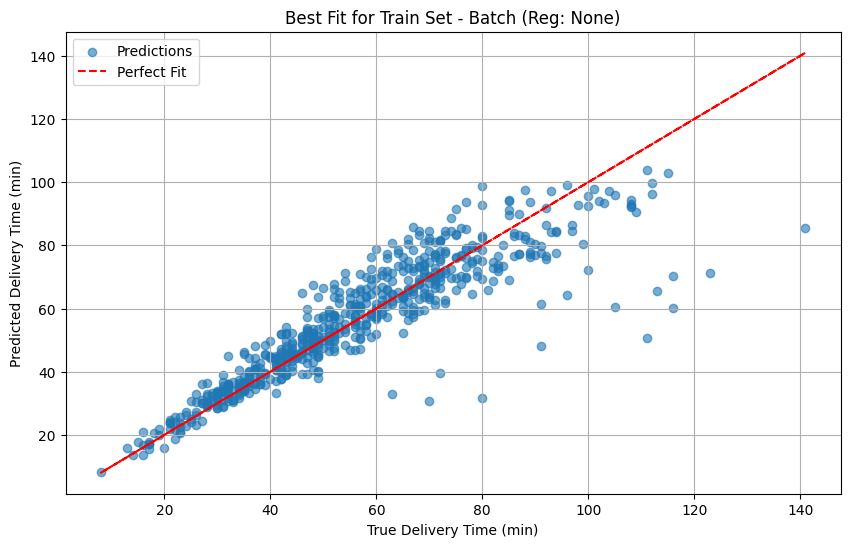

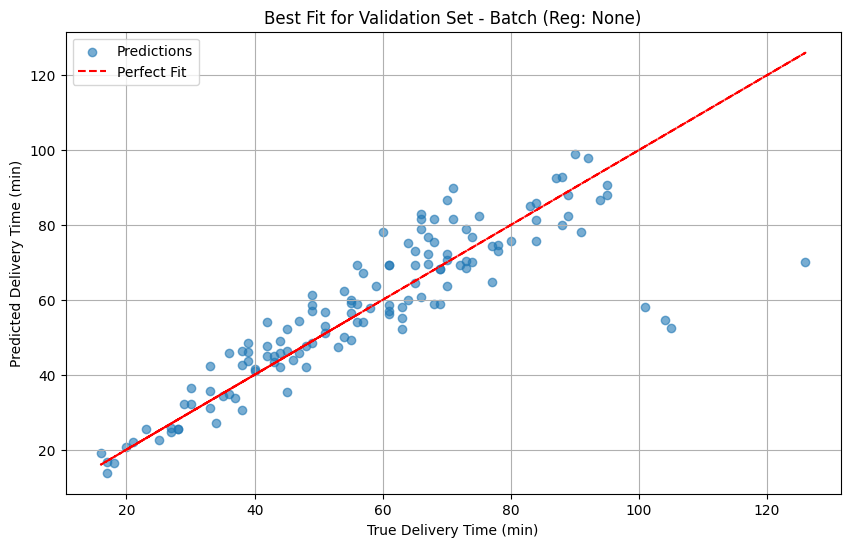

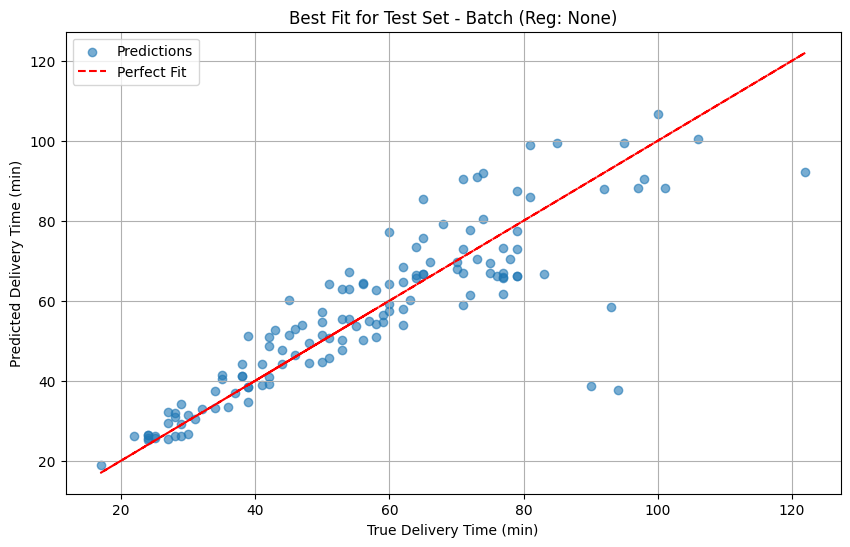

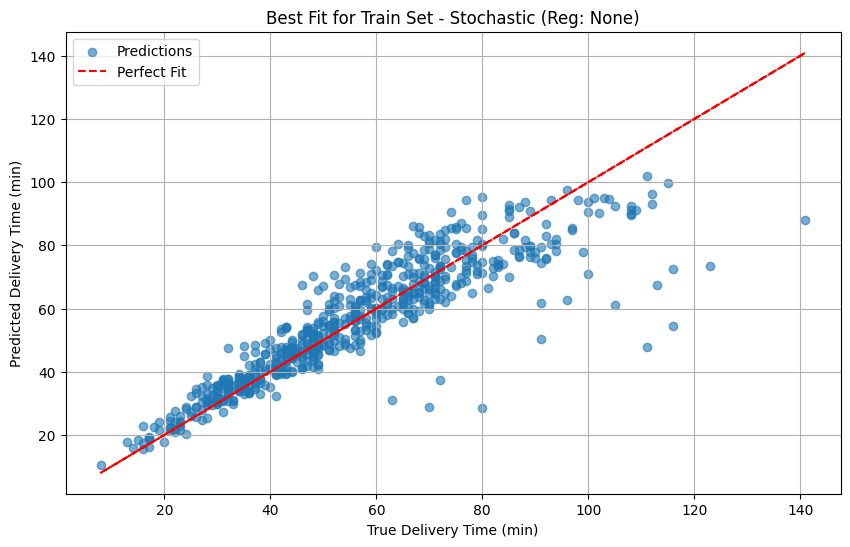

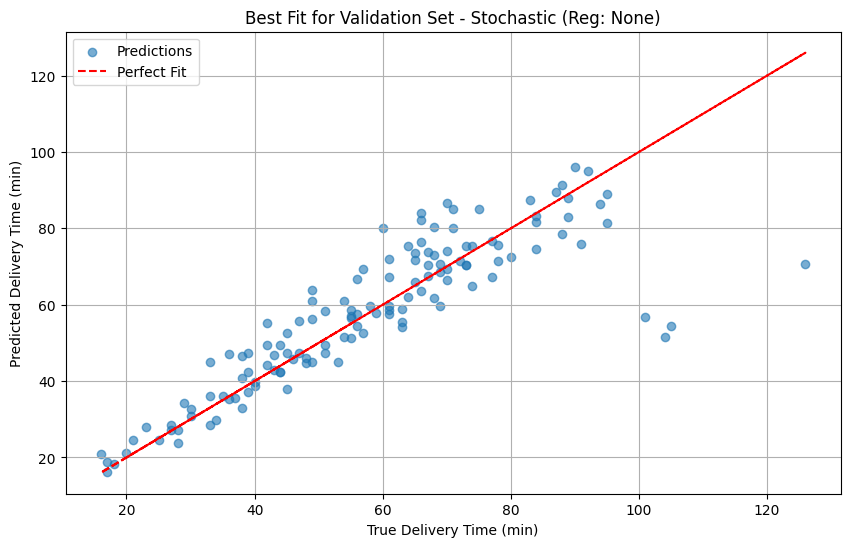

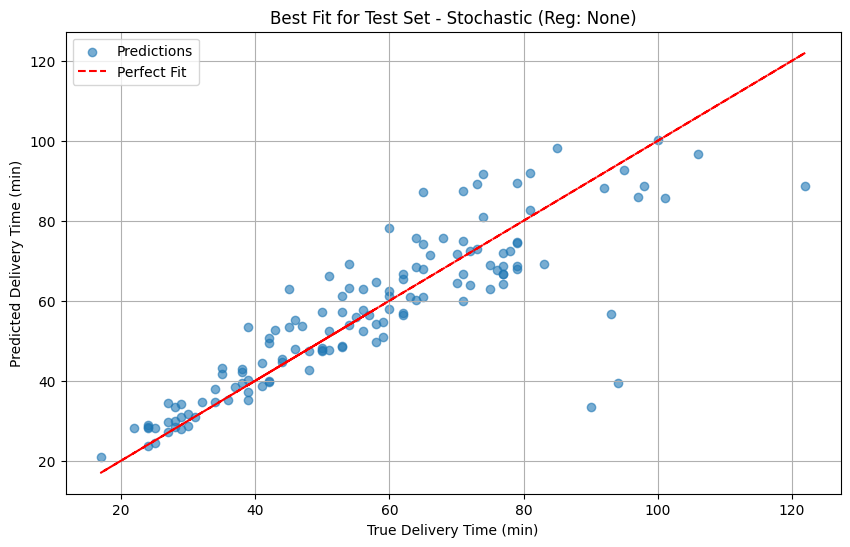

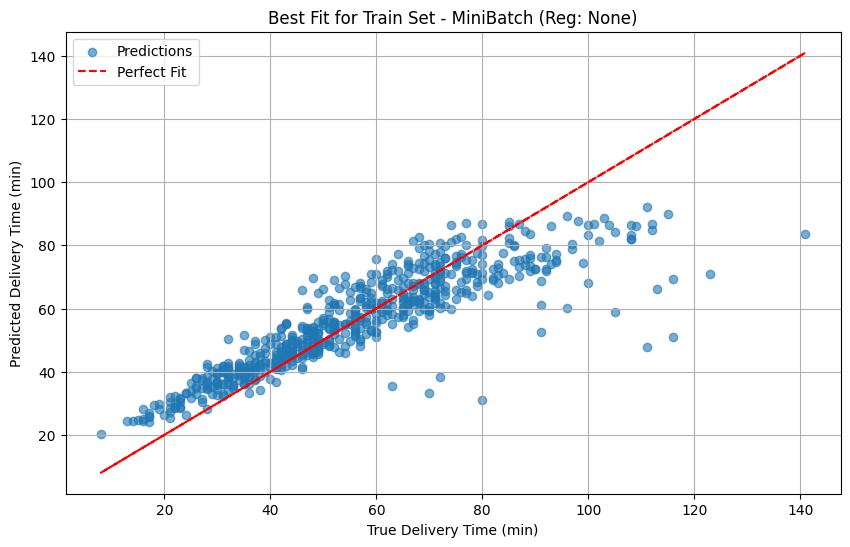

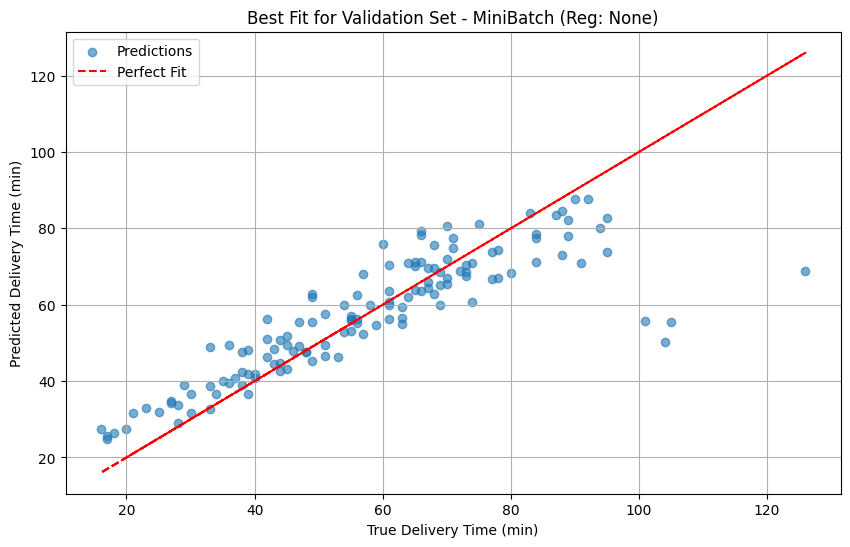

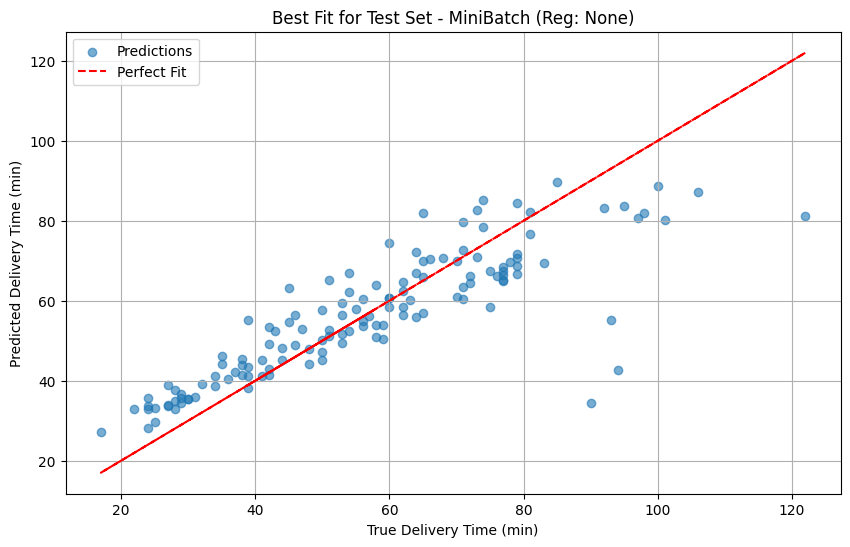

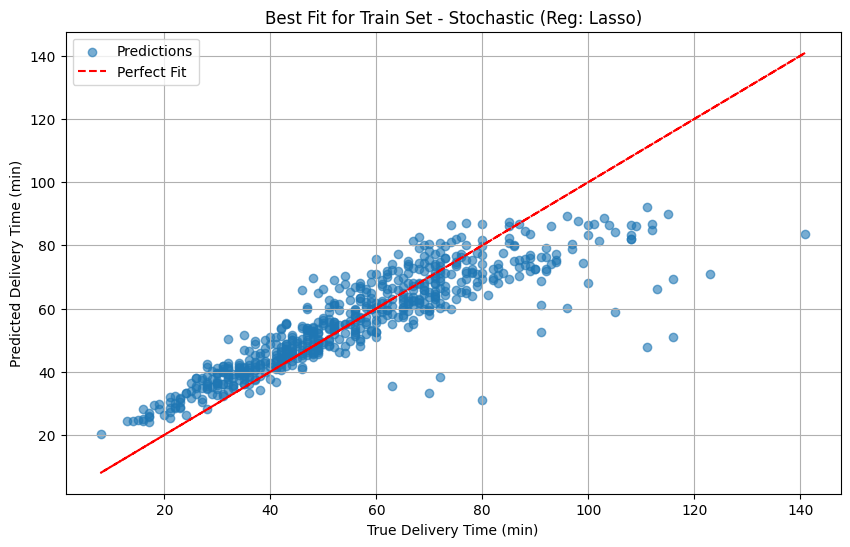

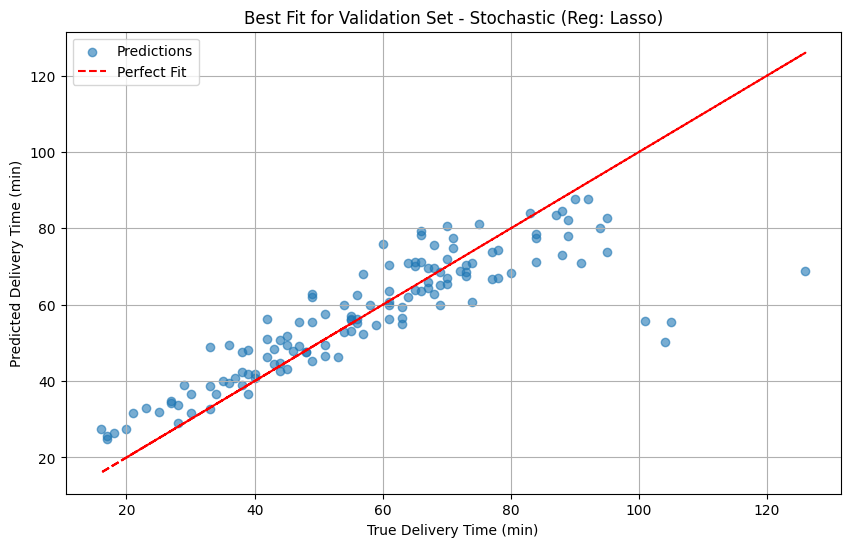

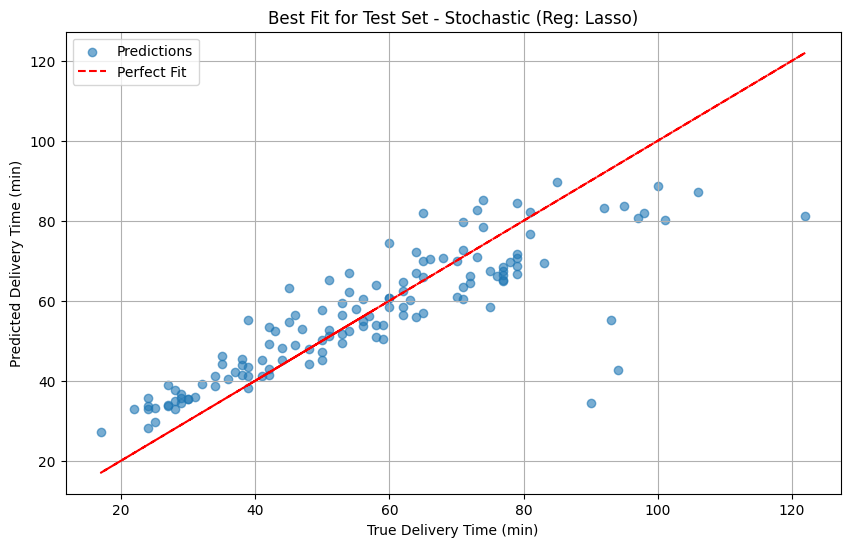

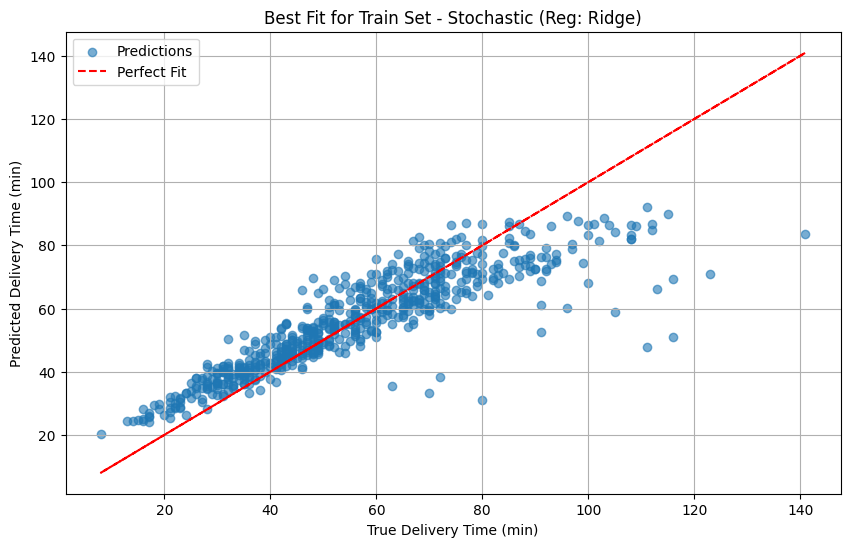

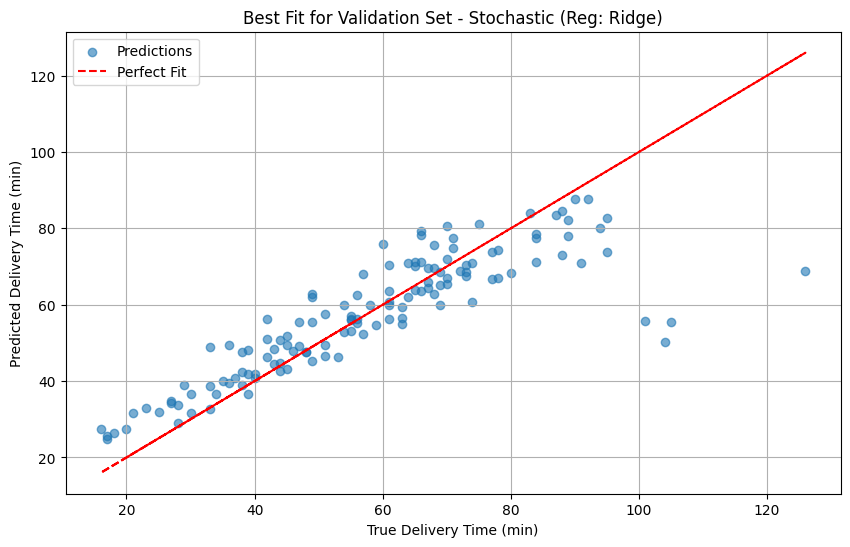

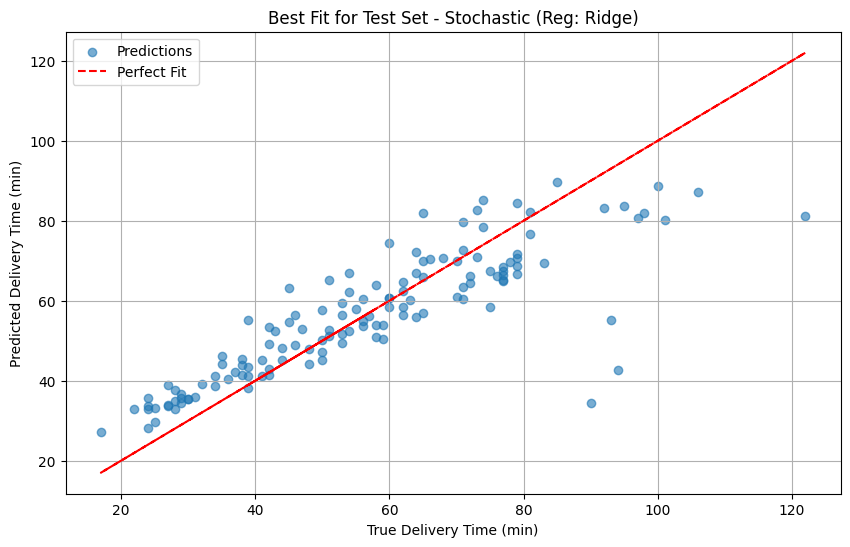

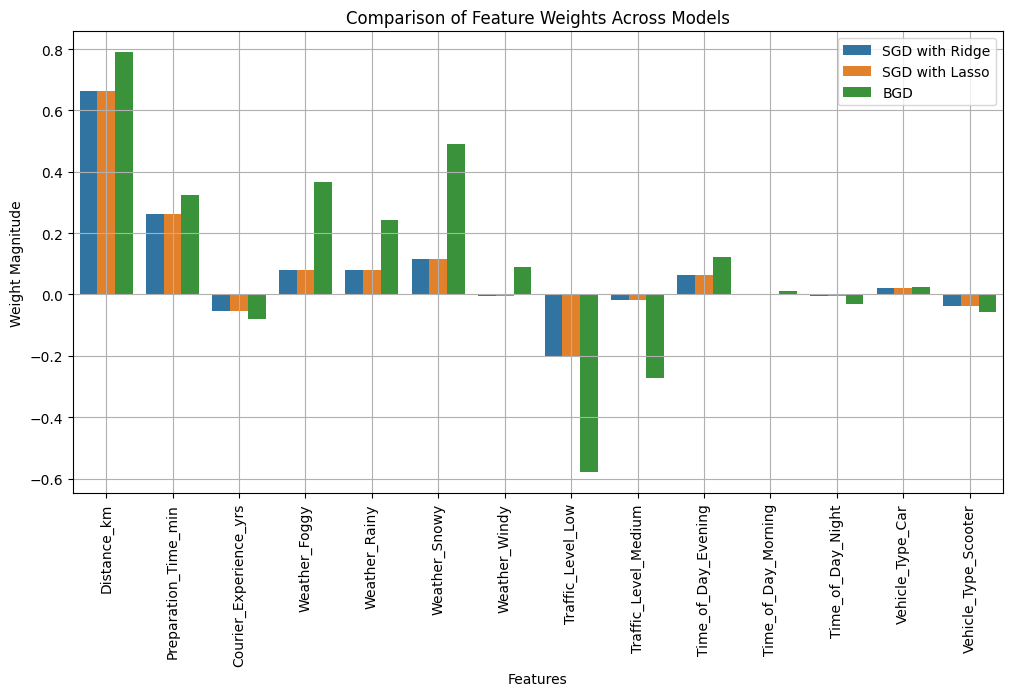

Features with little to no effect on delivery time for Batch model: []
Features with little to no effect on delivery time for Stochastic model: ['Time_of_Day_Morning', 'Time_of_Day_Night']
Features with little to no effect on delivery time for MiniBatch model: ['Weather_Windy', 'Time_of_Day_Morning', 'Time_of_Day_Night']


In [11]:
sgd_model_with_lasso = LinearRegressionModel(epochs, X_train, Y_train, X_val, Y_val, X_test, Y_test, Y_mean, Y_std, theta, gd_method='Stochastic', lr=0.0001, regularization='Lasso', Lambda=0.1, print_results=0)
sgd_model_with_lasso.train()
sgd_model_with_lasso.evaluate()
sgd_model_with_ridge = LinearRegressionModel(epochs, X_train, Y_train, X_val, Y_val, X_test, Y_test, Y_mean, Y_std, theta, gd_method='Stochastic', lr=0.0001, regularization='Ridge', Lambda=0.1, print_results=0)
sgd_model_with_ridge.train()
sgd_model_with_ridge.evaluate()
plot_best_fit(bgd_model, X_train, Y_train, "Train Set")
plot_best_fit(bgd_model, X_val, Y_val, "Validation Set")
plot_best_fit(bgd_model, X_test, Y_test, "Test Set")
plot_best_fit(sgd_model, X_train, Y_train, "Train Set")
plot_best_fit(sgd_model, X_val, Y_val, "Validation Set")
plot_best_fit(sgd_model, X_test, Y_test, "Test Set")
plot_best_fit(mbgd_model, X_train, Y_train, "Train Set")
plot_best_fit(mbgd_model, X_val, Y_val, "Validation Set")
plot_best_fit(mbgd_model, X_test, Y_test, "Test Set")
plot_best_fit(sgd_model_with_lasso, X_train, Y_train, "Train Set")
plot_best_fit(sgd_model_with_lasso, X_val, Y_val, "Validation Set")
plot_best_fit(sgd_model_with_lasso, X_test, Y_test, "Test Set")
plot_best_fit(sgd_model_with_ridge, X_train, Y_train, "Train Set")
plot_best_fit(sgd_model_with_ridge, X_val, Y_val, "Validation Set")
plot_best_fit(sgd_model_with_ridge, X_test, Y_test, "Test Set")
plot_feature_weights([sgd_model_with_ridge, sgd_model_with_lasso, bgd_model], ["SGD with Ridge", "SGD with Lasso", "BGD"], cols)
analyze_feature_effect(bgd_model, cols)
analyze_feature_effect(sgd_model, cols)
analyze_feature_effect(mbgd_model, cols)

In [12]:
print(bgd_model.iters_for_convergence)
print(sgd_model.iters_for_convergence)
print(mbgd_model.iters_for_convergence)

50
0
120
